<h1 align=center> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Project Topic: Investor sentiment Index (Standardised + Excluding Macroeconomic Factors) </h1>
<h3 align=center> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Author: JeffLin99, Email: jeffhengyu1999@hotmail.com</h3>

## Project Description:
### In this project, the goal is to find market sentiment proxies and construct a composite indicator of investor sentiment using principal component analysis

#### 1) Reading the csv of investor sentiment indicator variables
##### Data source: China Stock Market & Accounting Research Database

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as smt
import statsmodels.stats.diagnostic as smd

df1 = pd.read_csv('Data\QX_ISI.csv')
df1 = df1.set_index(['SgnMonth'])
df1.index = pd.to_datetime(df1.index)
df1

# Implications of the data expression:
#     DCEF: Average discount rate of closed funds in the previous month
#     RIPO: Average IPO First Day Returns
#     NIPO: Number of IPOs
#     NA: Number of new accounts opened
#     TURN: Previous month's market turnover rate
#     CCI: Previous month's consumer confidence
#     ISI: Investor Sentiment Index
#     StdISI: Investor sentiment index (standardised)
#     StdExMacroISI: Investor sentiment index (standardised - excluding macroeconomic factors)

,DCEF,RIPO,NIPO,NA,TURN,CCI,ISI,StdISI,StdExMacroISI
SgnMonth,,,,,,,,,
2003-01-01,-0.1034,0.9050,5,3.97,0.1054,97.5,26.44,-1.15,-1.17
2003-02-01,-0.1117,0.7691,3,2.85,0.1928,97.7,25.30,-0.96,-0.95
2003-03-01,-0.0941,0.6831,6,3.26,0.1328,97.8,26.20,-1.14,-1.19
2003-04-01,-0.1399,1.1853,5,5.69,0.1218,97.6,27.69,-1.01,-0.95
2003-05-01,-0.1892,1.0623,2,4.21,0.3197,88.7,24.05,-0.72,-0.71
...,...,...,...,...,...,...,...,...,...
2022-04-01,0.0318,0.0832,36,41.89,0.2734,113.2,61.10,0.88,0.59
2022-05-01,-0.0143,0.4557,18,40.09,0.2525,86.7,49.93,0.01,-0.41
2022-06-01,-0.0475,0.5093,31,44.34,0.2417,86.8,55.64,0.13,-0.38


#### 2) Since these three variables in the data, DCEF, TURN, CCI, etc., are from the previous month, they are levelled to give the current month's data and the previous month's data is eliminated

In [2]:
df1[['DCEF','TURN','CCI']] = df1[['DCEF','TURN','CCI']].shift(-1)
df1 = df1.iloc[:-1,:]
df1

,DCEF,RIPO,NIPO,NA,TURN,CCI,ISI,StdISI,StdExMacroISI
SgnMonth,,,,,,,,,
2003-01-01,-0.1117,0.9050,5,3.97,0.1928,97.7,26.44,-1.15,-1.17
2003-02-01,-0.0941,0.7691,3,2.85,0.1328,97.8,25.30,-0.96,-0.95
2003-03-01,-0.1399,0.6831,6,3.26,0.1218,97.6,26.20,-1.14,-1.19
2003-04-01,-0.1892,1.1853,5,5.69,0.3197,88.7,27.69,-1.01,-0.95
2003-05-01,-0.1962,1.0623,2,4.21,0.2558,85.7,24.05,-0.72,-0.71
...,...,...,...,...,...,...,...,...,...
2022-03-01,0.0318,0.3283,37,76.73,0.2734,113.2,85.40,1.69,1.52
2022-04-01,-0.0143,0.0832,36,41.89,0.2525,86.7,61.10,0.88,0.59
2022-05-01,-0.0475,0.4557,18,40.09,0.2417,86.8,49.93,0.01,-0.41


#### 3）Read data csv of macroeconomic variables
##### Data source: China Stock Market & Accounting Research Database (China Macroeconomic Research Database)

In [3]:
## Consumer price index (CPI)
df2 = pd.read_csv('Data\CME_Mpi1.csv')
df2 = df2[df2['Datasgn'] == 'PYP']   #Selecting statistics for the same period of the previous year
df2 = df2[df2['Areasgn'] == 1]   #Selected nationwide data
df2 = pd.DataFrame(df2[['Staper','Epim0101']])    #Select the required variables

## Business index of macro-economic(MCI)
df3 = pd.read_csv('Data\CME_Mbcid3.csv')

## Industrial Value Added Growth Rate (IAVR)
df4 = pd.read_csv('Data\CME_Mindustryvalueadd.csv')
df4 = df4[df4['Datasign'] == 'A']   #Selection of current month's data
df4 = df4[['Month','Valueadd']]   #Selection of required variables
df4 = df4.rename(columns={'Month':'Staper'})   #Rename column for consistency

# Implications of the data expression:
#     Epim0101: Consumer price index (CPI)
#     Bcidm0302: Business index of macro-economic(MCI)
#     Valueadd: Industrial Value Added Growth Rate (IAVR)

#### 4) Merge the above three data

In [4]:
df_merged = pd.merge(pd.merge(df2,df3,on=['Staper'],how='outer'),df4,on=['Staper'],how='outer')
del df_merged['Staper']
df_merged = df_merged.iloc[:len(df1)]
df_merged.index = df1.index
df_merged = df_merged.fillna(method='ffill')   #Fill missing values forward
df_merged

,Epim0101,Bcidm0302,Valueadd
SgnMonth,,,
2003-01-01,100.4,100.00,14.8
2003-02-01,100.3,100.91,19.8
2003-03-01,100.5,100.21,16.9
2003-04-01,100.6,99.09,14.9
2003-05-01,100.6,99.05,13.7
...,...,...,...
2022-03-01,101.1,99.80,5.0
2022-04-01,101.4,95.31,-2.9
2022-05-01,101.5,93.51,0.7


#### 5) Selection of control variables

In [5]:
data = df1.loc[:,['DCEF','RIPO','NIPO','NA','TURN','CCI']]
data1 = data.copy()   #Duplicate DF to differentiate the created variable lag term time series

#Time series of lagged terms of variables created (t-1)
for i in data.columns:
    data1[i+'_lagged'] = data[i].shift(1)

#Fill missing values forward
data1 = pd.DataFrame(data1).fillna(method='bfill').set_index(data1.index)
data1

,DCEF,RIPO,NIPO,NA,TURN,CCI,DCEF_lagged,RIPO_lagged,NIPO_lagged,NA_lagged,TURN_lagged,CCI_lagged
SgnMonth,,,,,,,,,,,,
2003-01-01,-0.1117,0.9050,5,3.97,0.1928,97.7,-0.1117,0.9050,5.0,3.97,0.1928,97.7
2003-02-01,-0.0941,0.7691,3,2.85,0.1328,97.8,-0.1117,0.9050,5.0,3.97,0.1928,97.7
2003-03-01,-0.1399,0.6831,6,3.26,0.1218,97.6,-0.0941,0.7691,3.0,2.85,0.1328,97.8
2003-04-01,-0.1892,1.1853,5,5.69,0.3197,88.7,-0.1399,0.6831,6.0,3.26,0.1218,97.6
2003-05-01,-0.1962,1.0623,2,4.21,0.2558,85.7,-0.1892,1.1853,5.0,5.69,0.3197,88.7
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01,0.0318,0.3283,37,76.73,0.2734,113.2,0.0459,0.4208,17.0,47.15,0.2499,120.5
2022-04-01,-0.0143,0.0832,36,41.89,0.2525,86.7,0.0318,0.3283,37.0,76.73,0.2734,113.2
2022-05-01,-0.0475,0.4557,18,40.09,0.2417,86.8,-0.0143,0.0832,36.0,41.89,0.2525,86.7


#### 6) Tabular data merging ISI variables with macroeconomic variables

In [6]:
data_ols = pd.merge(data1,df_merged,left_index=True,right_index=True)

#### 7) Each ISI variable is regressed on a macroeconomic variable and its residual series are extracted to remove the effect of the macroeconomic variable on the ISI variable

In [7]:
ols_resid = pd.DataFrame(index = data1.index)
for i in data1.columns:
    ols = smf.ols(formula = i+'~'+'Epim0101 + Bcidm0302 + Valueadd', data=data_ols).fit()
    ols_resid[str(i)+'_resid'] = ols.resid

ols_resid

,DCEF_resid,RIPO_resid,NIPO_resid,NA_resid,TURN_resid,CCI_resid,DCEF_lagged_resid,RIPO_lagged_resid,NIPO_lagged_resid,NA_lagged_resid,TURN_lagged_resid,CCI_lagged_resid
SgnMonth,,,,,,,,,,,,
2003-01-01,0.089045,0.302076,-5.708711,-33.486107,-0.111836,-1.296800,0.091387,0.345395,-4.734123,-30.735198,-0.112635,-1.207476
2003-02-01,0.168402,0.122313,-1.366806,-32.949061,-0.183800,6.367579,0.153497,0.321670,1.979270,-28.079264,-0.126533,6.531540
2003-03-01,0.087264,0.063777,-1.743377,-33.481417,-0.186567,2.010986,0.135534,0.199414,-3.643764,-30.804704,-0.177028,2.366426
2003-04-01,0.016510,0.606514,-4.046909,-31.227267,0.011964,-9.135766,0.068462,0.144940,-2.080515,-30.852742,-0.185939,-0.180594
2003-05-01,-0.006058,0.488862,-8.861580,-33.212803,-0.048256,-14.139132,0.003440,0.648027,-4.985326,-29.187237,0.015944,-11.118673
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01,0.103423,-0.252584,11.380114,34.553692,0.011906,-1.993194,0.118040,-0.163660,-8.574918,4.978924,-0.010061,5.116051
2022-04-01,-0.026932,-0.333042,5.322551,-0.866398,-0.008615,-37.341494,0.020501,-0.125700,5.869598,32.960720,0.019641,-11.430724
2022-05-01,-0.005069,0.083119,-4.109929,0.124579,-0.041920,-29.274744,0.030784,-0.315404,13.760673,2.031739,-0.022935,-29.936948


#### 8)Standardised deformation of all data

In [8]:
scaler = StandardScaler()
scaler.fit(ols_resid.values)
scaled_ols_resid = pd.DataFrame(scaler.transform(ols_resid))
scaled_ols_resid.index = ols_resid.index
scaled_ols_resid.columns = ols_resid.columns
scaled_ols_resid

C:\Users\Myth.God\Anaconda3-Y2023\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,DCEF_resid,RIPO_resid,NIPO_resid,NA_resid,TURN_resid,CCI_resid,DCEF_lagged_resid,RIPO_lagged_resid,NIPO_lagged_resid,NA_lagged_resid,TURN_lagged_resid,CCI_lagged_resid
SgnMonth,,,,,,,,,,,,
2003-01-01,1.348918,0.452164,-0.434936,-0.788741,-0.946036,-0.174077,1.402230,0.517647,-0.366313,-0.725360,-0.946199,-0.166245
2003-02-01,2.551066,0.183085,-0.104134,-0.776091,-1.554781,0.854756,2.355245,0.482090,0.153150,-0.662679,-1.062954,0.899261
2003-03-01,1.321928,0.095464,-0.132825,-0.788630,-1.578191,0.269946,2.079627,0.298864,-0.281944,-0.727000,-1.487143,0.325809
2003-04-01,0.250107,0.907863,-0.308327,-0.735535,0.101203,-1.226345,1.050477,0.217223,-0.160984,-0.728134,-1.562004,-0.024864
2003-05-01,-0.091775,0.731756,-0.675147,-0.782303,-0.408206,-1.897974,0.052781,0.971206,-0.385750,-0.688827,0.133937,-1.530817
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01,1.566720,-0.378081,0.867030,0.813887,0.100713,-0.267558,1.811191,-0.245279,-0.663503,0.117504,-0.084519,0.704377
2022-04-01,-0.407981,-0.498516,0.405515,-0.020407,-0.072875,-5.012557,0.314572,-0.188387,0.454173,0.777883,0.164998,-1.573781
2022-05-01,-0.076782,0.124416,-0.313128,0.002934,-0.354603,-3.929712,0.472343,-0.472700,1.064762,0.047950,-0.192666,-4.121715


#### 9) Define the principal component analysis function

In [9]:
import numpy as np

def pca(X,k):#k is the components you want
    #mean of each feature
    n_samples, n_features = X.shape
    scatter_matrix=np.dot(np.transpose(X),X)/n_samples
    #Calculate the eigenvectors and eigenvalues
    eig_val, eig_vec = np.linalg.eig(scatter_matrix)
    eig_pairs = [(np.abs(eig_val[i]), eig_vec[:,i]) for i in range(n_features)]
    # sort eig_vec based on eig_val from highest to lowest
    eig_pairs.sort(reverse=True)
    # select the top k eig_vec
    feature=np.array([ele[1] for ele in eig_pairs[:k]])
    #get new data
    data=np.dot(X,np.transpose(feature))
    return data, eig_vec

#### 10) Establishing a preliminary principal component analysis

In [10]:
all_pca_ols_resid, pca_component1 = pca(scaled_ols_resid.values, len(scaled_ols_resid.columns))
all_pca_ols_resid = pd.DataFrame(all_pca_ols_resid*(-1))
pca_component1 = pca_component1*(-1)
pca1_ols_resid = pd.DataFrame(all_pca_ols_resid[0].tolist())   #Principal Component Analysis 1
pca1_ols_resid.index = ols_resid.index
pca1_ols_resid.columns = ['PCA1']
pca1_ols_resid

,PCA1
SgnMonth,
2003-01-01,0.768489
2003-02-01,0.048801
2003-03-01,0.918992
2003-04-01,0.900758
2003-05-01,1.146853
...,...
2022-03-01,-0.966778
2022-04-01,0.806099
2022-05-01,1.436742


#### 11) Scatterplotting of principal and secondary components

Text(0, 0.5, 'PCA2')

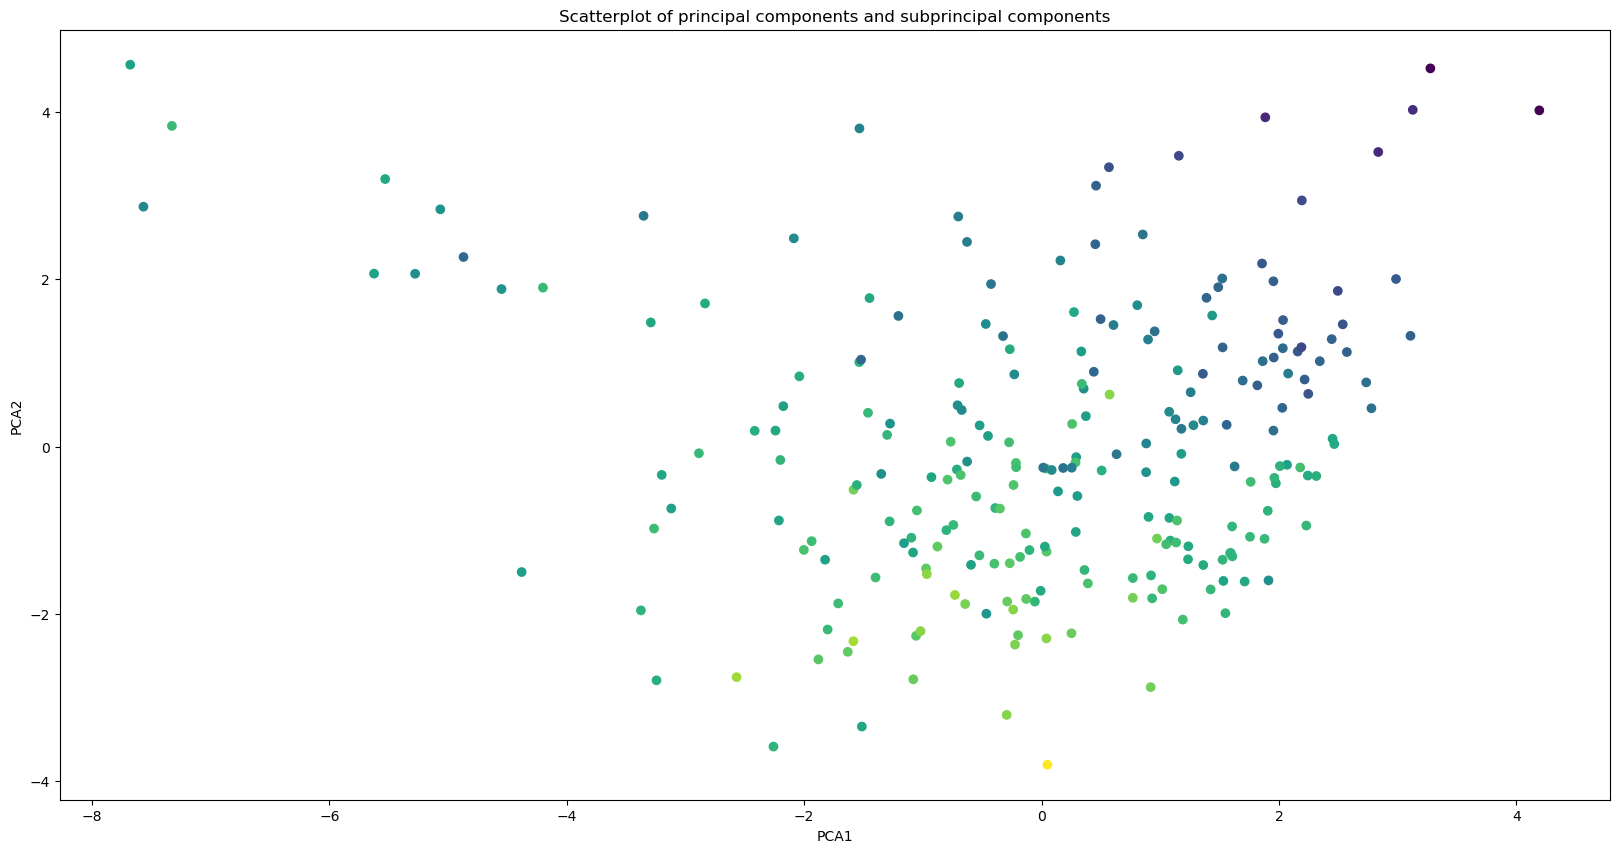

In [11]:
plt.figure(figsize=(20, 10))
plt.scatter(all_pca_ols_resid.iloc[:,0], all_pca_ols_resid.iloc[:,1], c=scaled_ols_resid.iloc[:,0].values)
plt.title('Scatterplot of principal components and subprincipal components')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

#### 12) Calculate the covariance matrix of all the above variables and their lagged terms with the principal components

In [12]:
cov_data = scaled_ols_resid.join(pca1_ols_resid)
cov_matrix = pd.DataFrame(np.cov(cov_data.T))
cov_matrix.columns = cov_data.columns
cov_matrix.index =cov_data.columns
cov_matrix

,DCEF_resid,RIPO_resid,NIPO_resid,NA_resid,TURN_resid,CCI_resid,DCEF_lagged_resid,RIPO_lagged_resid,NIPO_lagged_resid,NA_lagged_resid,TURN_lagged_resid,CCI_lagged_resid,PCA1
DCEF_resid,1.004274,0.093252,0.454667,0.109545,-0.150611,0.161571,0.937753,0.091407,0.423885,0.090128,-0.091536,0.168560,-0.713169
RIPO_resid,0.093252,1.004274,0.181459,0.425550,0.261033,0.176022,0.074567,0.460795,0.155426,0.383237,0.267781,0.195729,-1.111825
NIPO_resid,0.454667,0.181459,1.004274,0.263781,0.148504,0.211732,0.416462,0.200246,0.687892,0.219036,0.153550,0.241734,-1.125570
NA_resid,0.109545,0.425550,0.263781,1.004274,0.681355,0.126822,0.124112,0.358950,0.203080,0.816579,0.607232,0.138281,-1.612161
TURN_resid,-0.150611,0.261033,0.148504,0.681355,1.004274,-0.030691,-0.131384,0.187148,0.149746,0.551592,0.783835,-0.030393,-1.238792
CCI_resid,0.161571,0.176022,0.211732,0.126822,-0.030691,1.004274,0.127869,0.137783,0.214612,0.102992,-0.028331,0.924423,-0.686110
DCEF_lagged_resid,0.937753,0.074567,0.416462,0.124112,-0.131384,0.127869,1.004274,0.070753,0.420313,0.089025,-0.130387,0.158795,-0.680473
RIPO_lagged_resid,0.091407,0.460795,0.200246,0.358950,0.187148,0.137783,0.070753,1.004274,0.173826,0.417061,0.260971,0.164307,-1.062258
NIPO_lagged_resid,0.423885,0.155426,0.687892,0.203080,0.149746,0.214612,0.420313,0.173826,1.004274,0.254294,0.158410,0.216602,-1.090132
NA_lagged_resid,0.090128,0.383237,0.219036,0.816579,0.551592,0.102992,0.089025,0.417061,0.254294,1.004274,0.692030,0.116226,-1.585209


#### 13) Calculate the correlation coefficients of all the above variables and their lagged terms with the principal components

In [13]:
corr = pd.DataFrame(index = ols_resid.T.index)
corr['Corr_PCA1'] = np.nan
for i in range(len(ols_resid.columns)):
    corr['Corr_PCA1'].iloc[i] = scaled_ols_resid.iloc[:,i].corr(pca1_ols_resid.iloc[:,0])
corr

,Corr_PCA1
DCEF_resid,-0.360734
RIPO_resid,-0.562382
NIPO_resid,-0.569334
NA_resid,-0.815461
TURN_resid,-0.626604
CCI_resid,-0.347047
DCEF_lagged_resid,-0.344196
RIPO_lagged_resid,-0.537310
NIPO_lagged_resid,-0.551409
NA_lagged_resid,-0.801828


#### 14) Between screening variables or one of the lagged terms of a variable, the higher is chosen by their correlation coefficients with the principal components

In [14]:
scaled_ols_resid_2 = pd.DataFrame(index=ols_resid.index)
for i in range(len(data.columns)):
    if (corr.iloc[i][0] > corr.iloc[i + len(data.columns)][0]):
        scaled_ols_resid_2 = scaled_ols_resid_2.merge(pd.DataFrame(scaled_ols_resid.iloc[:,i]), left_index=True, right_index=True)
    else:
        scaled_ols_resid_2 = scaled_ols_resid_2.merge(pd.DataFrame(scaled_ols_resid.iloc[:,i + len(data.columns)]), left_index=True, right_index=True)

scaled_ols_resid_2   #The dataset that will be used for the final principal component analysis modelling

,DCEF_lagged_resid,RIPO_lagged_resid,NIPO_lagged_resid,NA_lagged_resid,TURN_resid,CCI_resid
SgnMonth,,,,,,
2003-01-01,1.402230,0.517647,-0.366313,-0.725360,-0.946036,-0.174077
2003-02-01,2.355245,0.482090,0.153150,-0.662679,-1.554781,0.854756
2003-03-01,2.079627,0.298864,-0.281944,-0.727000,-1.578191,0.269946
2003-04-01,1.050477,0.217223,-0.160984,-0.728134,0.101203,-1.226345
2003-05-01,0.052781,0.971206,-0.385750,-0.688827,-0.408206,-1.897974
...,...,...,...,...,...,...
2022-03-01,1.811191,-0.245279,-0.663503,0.117504,0.100713,-0.267558
2022-04-01,0.314572,-0.188387,0.454173,0.777883,-0.072875,-5.012557
2022-05-01,0.472343,-0.472700,1.064762,0.047950,-0.354603,-3.929712


#### 15) Establishing a preliminary principal component analysis

In [15]:
all_pca_ols_resid_2, pca_component2 = pca(scaled_ols_resid_2.values, len(scaled_ols_resid_2.columns))
all_pca_ols_resid_2 = pd.DataFrame(all_pca_ols_resid_2*(-1))
pca_component2 = pca_component2*(-1)
pca1_ols_resid_2 = pd.DataFrame(all_pca_ols_resid_2[0].tolist())   #Principal Component Analysis 1
pca1_ols_resid_2.index = data.index
pca1_ols_resid_2.columns = ['PCA1']
pca1_ols_resid_2

,PCA1
SgnMonth,
2003-01-01,-0.453379
2003-02-01,-0.002531
2003-03-01,-0.519074
2003-04-01,-0.379796
2003-05-01,-0.730088
...,...
2022-03-01,0.083006
2022-04-01,-0.549263
2022-05-01,-0.660217


#### 16) Final coefficients for each variable in the investor sentiment (standardised) indicator

In [16]:
result = []
for i in range(len(pca_component2)):
    result.append(pca_component2[i][0])
result = pd.DataFrame(result).T
result.columns = scaled_ols_resid_2.columns
result.index = ["Coef"]
result

,DCEF_lagged_resid,RIPO_lagged_resid,NIPO_lagged_resid,NA_lagged_resid,TURN_resid,CCI_resid
Coef,0.23792,0.441205,0.434258,0.572198,0.424129,0.229905


#### 17) Scatterplotting the data after screening the variables for principal components and subprincipal components

Text(0, 0.5, 'PCA2')

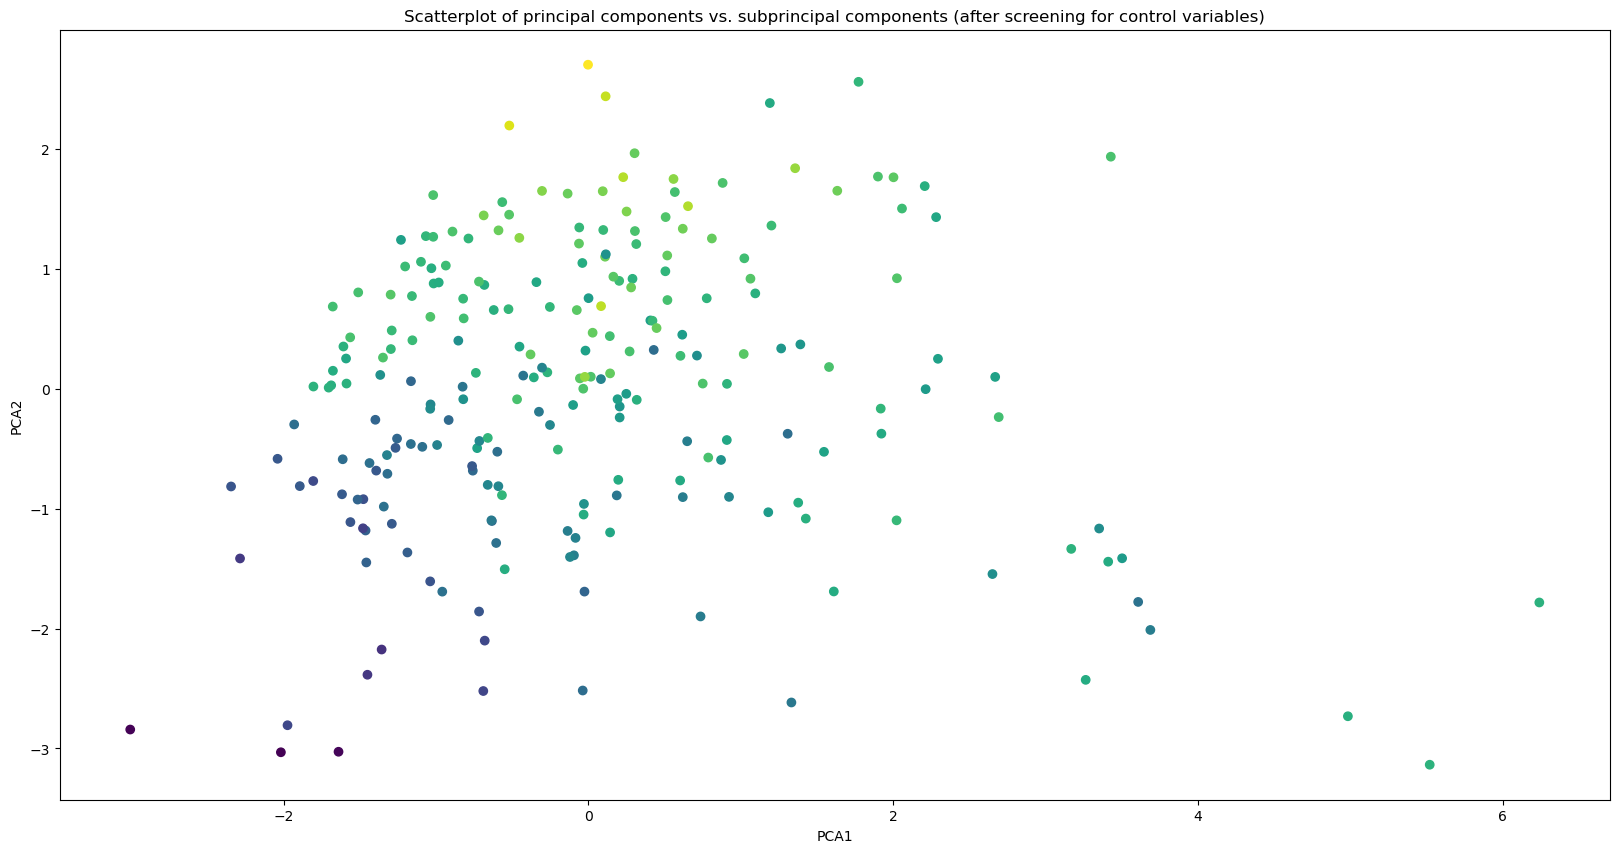

In [17]:
plt.figure(figsize=(20, 10))
plt.scatter(all_pca_ols_resid_2.iloc[:,0], all_pca_ols_resid_2.iloc[:,1], c=scaled_ols_resid_2.iloc[:,0].values)
plt.title('Scatterplot of principal components vs. subprincipal components (after screening for control variables)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

#### 18) Calculation of investor sentiment indicators (after excluding macro variables + standardisation)

In [18]:
sentiment = pd.DataFrame(index = data.index)
proxy = pd.DataFrame(index = scaled_ols_resid_2.index)
for i in range(len(all_pca_ols_resid_2.values[0])):
        proxy['proxy_'+str(i)] = scaled_ols_resid_2[scaled_ols_resid_2.columns[i]]*result.values[0][i]

sentiment['Std_ExMacro_ISI'] = proxy.sum(axis=1)
sentiment

,Std_ExMacro_ISI
SgnMonth,
2003-01-01,-0.453379
2003-02-01,-0.002531
2003-03-01,-0.519074
2003-04-01,-0.379796
2003-05-01,-0.730088
...,...
2022-03-01,0.083006
2022-04-01,-0.549263
2022-05-01,-0.660217


#### 19) Draw a graph of the estimated investor sentiment indicator against the (excluded macro variables + standardised) investor sentiment indicator from the data source

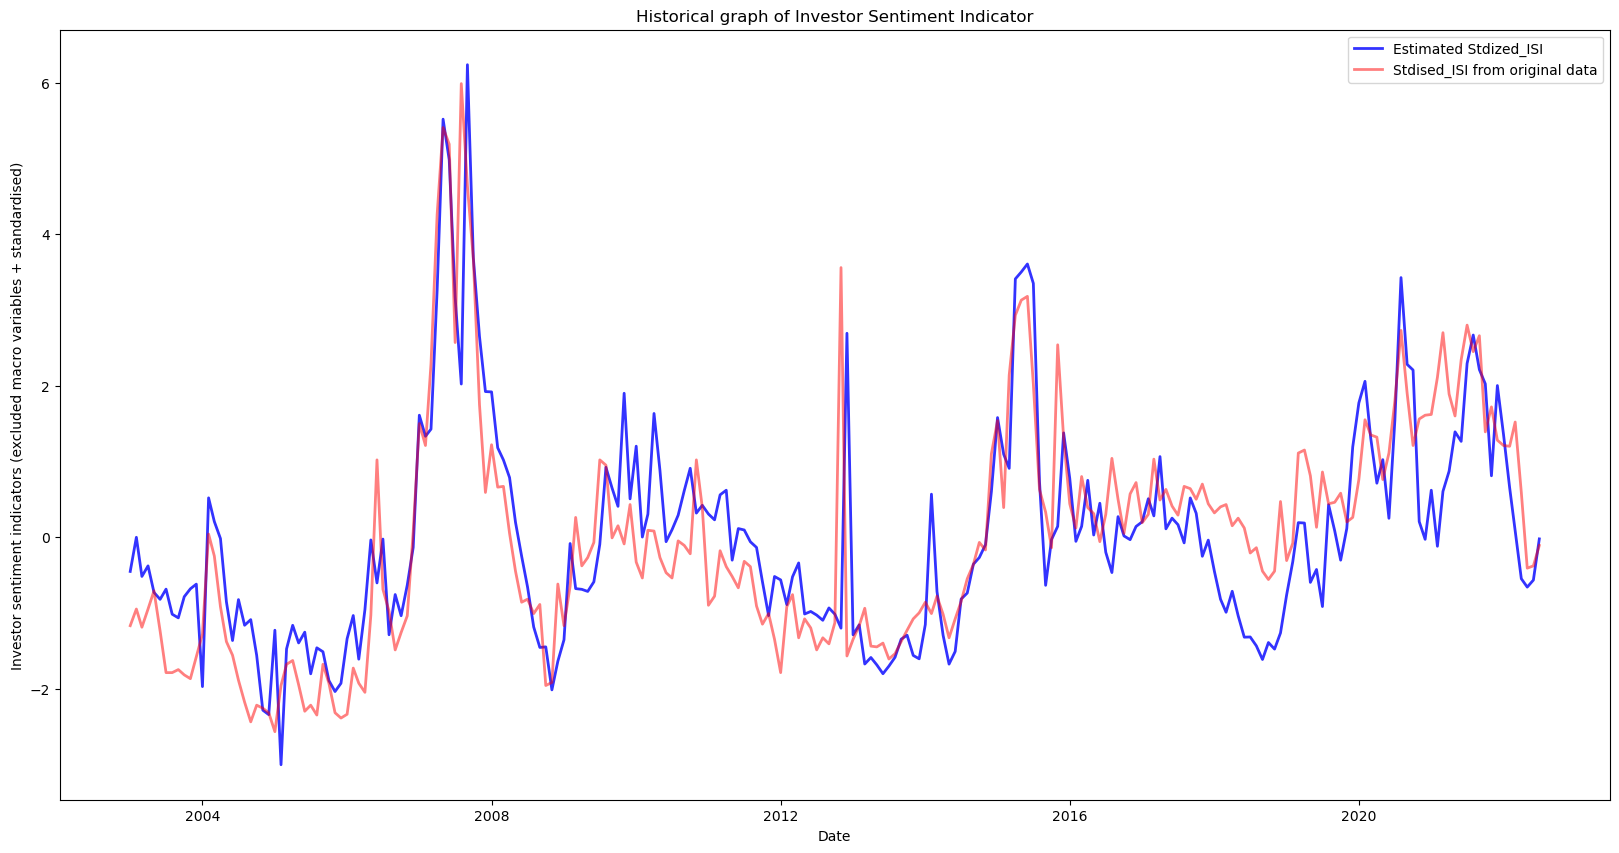

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(sentiment, linewidth = 2, color = 'blue', alpha = 0.8, label = 'Estimated Stdized_ISI')
plt.plot(df1['StdExMacroISI'], linewidth = 2, color = 'red', alpha = 0.5, label = 'Stdised_ISI from original data')
plt.title('Historical graph of Investor Sentiment Indicator')
plt.xlabel('Date')
plt.ylabel('Investor sentiment indicators (excluded macro variables + standardised)')
plt.legend()
plt.show()